<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 9: Filterung
## Cavity beneath hill
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In diesem Notebook modellieren wir eine Höhle unter einem Hügel. Die Höhle ist lufterfüllt,
die Sedimentfüllung des Höhlenboden ist remanent magnetisch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib_modelling
lib_modelling.change_fontsize()

In [2]:
def change_fontsize(SMALL_SIZE=15,MEDIUM_SIZE=20,BIGGER_SIZE=25):
    """
    re-set matplotlib fonts with three different sizes:
    SMALL_SIZE=15 (default)
    MEDIUM_SIZE=20 (default)
    BIGGER_SIZE=25 (default)
    """
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    


Wir nutzen die Funktionen, die wir für die Vorhersage des Schwerefeldes und de Magnetfeldes
der Kugel geschrieben haben ...

----
## 3D model of topography

<img src=figures/cave.jpg style=width:12cm>

Wir definieren ein Messgitter über der *Höhle*, mit $x \in [-50,50]$ m
und $y \in [-50,50]$ m.

In [3]:
def plot_topo(X,Y,TOPO):
    fig,axs = plt.subplots(1,2,figsize=(12.0,9.0))

    axs[0].set_title('Topography')
    axs[0].set_aspect('equal')
    axs[0].set_xlabel('Easting [m]')
    axs[0].set_ylabel('Northing [m]')
    CS1=axs[0].contourf(X, Y, TOPO,cmap=plt.cm.jet_r)
    CS2= axs[0].contour(X, Y, TOPO,colors='white')
    axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
    cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
    cbar.ax.set_xlabel('Topography [m]')

    axs[1].set_title('Profile W-E')
    #axs[1].set_aspect('equal')
    axs[1].set_xlabel('Easting [m]')
    axs[1].set_ylabel('Topography [m]')
    axs[1].plot(X[50,:], TOPO[50,:])
    return

In [4]:
def topo(nx=101,ny=101,amplitude=0.01,type=1,plot=True):
    x = np.linspace(-50, 50, nx)
    y = np.linspace(-50, 50, ny)
    # re-mesh for 2D plot
    X, Y = np.meshgrid(y,x)
    if (type == 0):
        TOPO = 200. + 0*X
    elif (type == 1):
        TOPO = 200. + amplitude + amplitude*np.cos(np.pi*X/50) + 0*X
    elif (type == 2):
        TOPO = 200. + amplitude + amplitude*np.sin(np.pi*X/100) + 0*X
    #print(TOPO.shape)
    #print(TOPO.min(),TOPO.max())

    ZTOP = 1000.
    Z = ZTOP - TOPO
    #print(ZTOP.shape)
    #print(Z.shape)
    #print(Z.min(),Z.max())
    if (plot):
        plot_topo(X,Y,TOPO)
    return X,Y,TOPO,Z,ZTOP

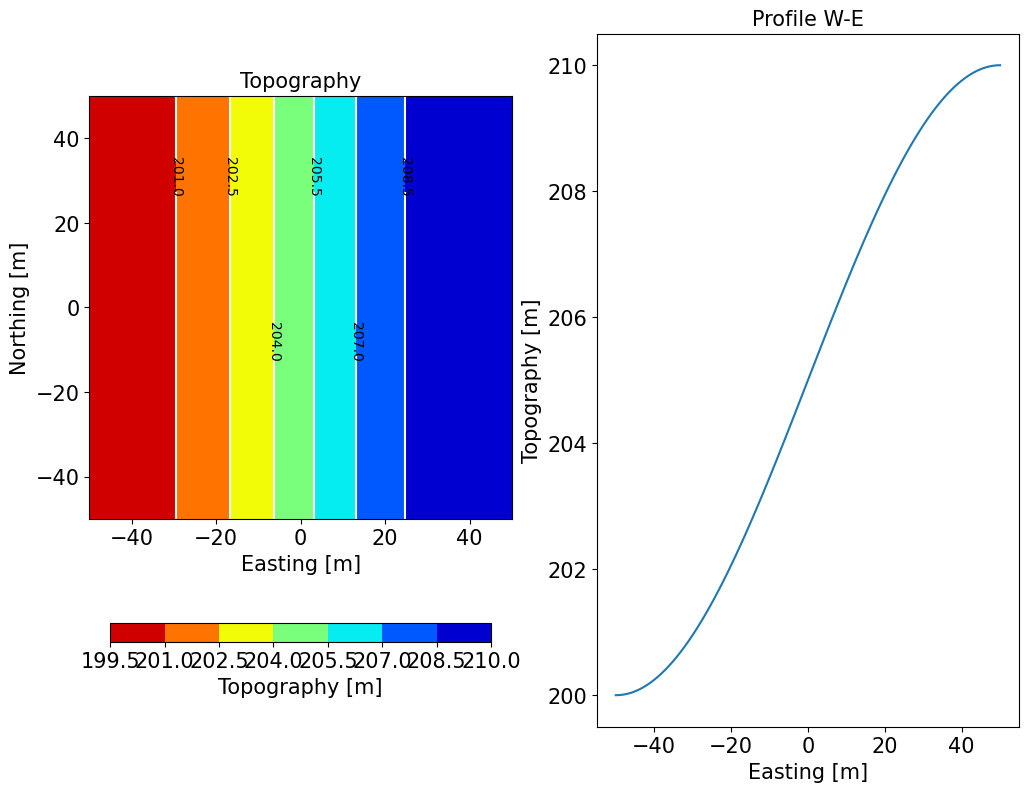

In [5]:
X,Y,TOPO,Z,ZTOP = topo(nx=101,ny=101,amplitude=5.0,type=2,plot=True)

## Gravity and magnetic anomaly

In [6]:
def signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG):
    boug = np.zeros(nx*ny).reshape(nx,ny)
    total = np.zeros(nx*ny).reshape(nx,ny)
    for i in range(boug.shape[0]):
        for j in range(boug.shape[1]):
            for k in range(len(XP)):
                gx,gy,gz = lib_modelling.grav_sphere(xo=X[i,j],yo=Y[i,j],zo=Z[i,j],
                                       xp=XP[k],yp=YP[k],zp=ZTOP-ZP[k],radius=RP[k],rho=RHOP[k])
                boug[i,j] = boug[i,j] + gz
                bx,by,bz,t = lib_modelling.mag_sphere(xo=X[i,j],yo=Y[i,j],zo=Z[i,j],
                                        xp=XP[k],yp=YP[k],zp=ZTOP-ZP[k],radius=RP[k],
                                earthincl=67.,earthdecl=0.,mag=MAG[k],incl=90.,decl=0.,theta=0.)
                total[i,j] = total[i,j] + t
    # plot gravity and total-field anomaly            
    fig,axs = plt.subplots(1,2,figsize=(14.0,9.0))

    axs[0].set_title('Cavity')

    axs[0].set_xlabel('Easting [m]')
    axs[0].set_ylabel('Northing [m]')
    CS1=axs[0].contourf(X, Y, boug,cmap=plt.cm.jet_r)
    CS2= axs[0].contour(X, Y, boug,colors='white')
    axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
    cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
    cbar.ax.set_xlabel('Gravity [mGal]')

    levels = np.array([i for i in np.linspace(-100,100,21)])
    axs[1].set_xlabel('Easting [m]')
    #axs[1].set_ylabel('Northing [m]')
    CS3=axs[1].contourf(X, Y, total,cmap=plt.cm.jet)
    CS4= axs[1].contour(X, Y, total,colors='white',levels=levels)
    axs[1].clabel(CS4, inline=1, fontsize=10,fmt='%5.1f',colors='black')
    cbar = fig.colorbar(CS3,ax=axs[1],orientation="horizontal",shrink=0.9)
    cbar.ax.set_xlabel('Total field [nT]')

## Compare different scenarios

### One sphere, flat topography

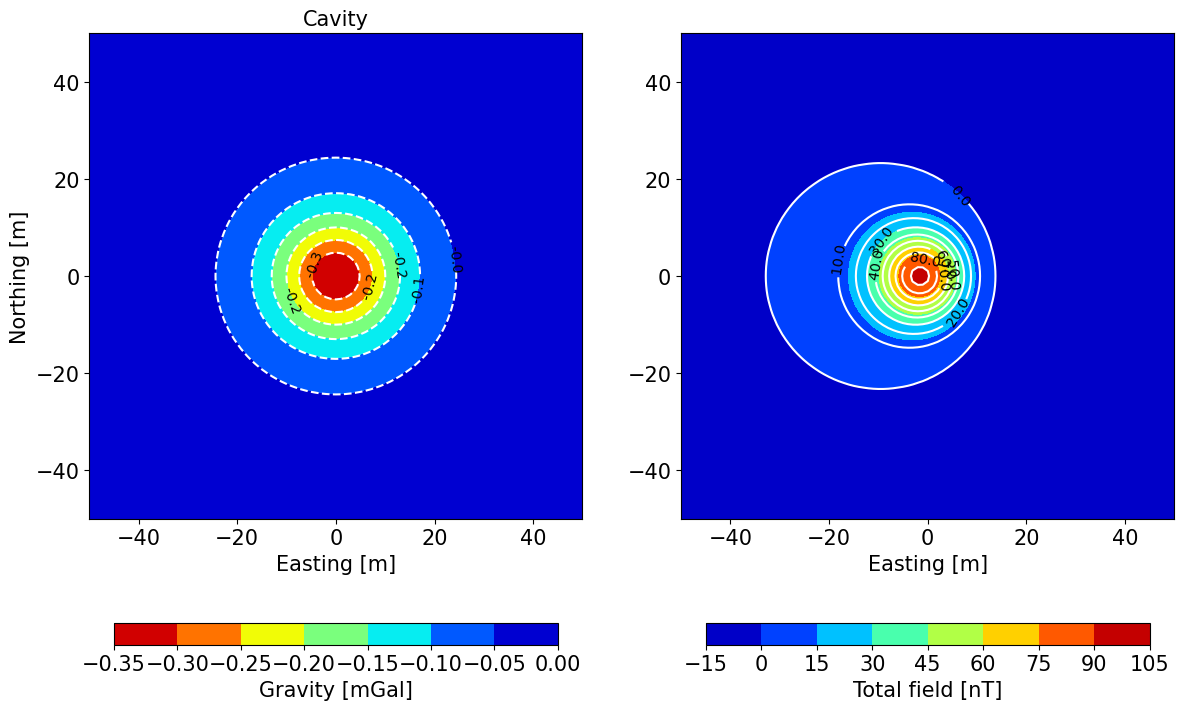

In [7]:
nx=101;ny=101

XP=[0.]
YP=[0.]
ZP=[185.]
RP =[10.]
RHOP =[-2800]
MAG = [0.4]

X,Y,TOPO,Z,ZTOP = topo(nx,ny,amplitude=0.0,type=0,plot=False)
signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)

### Two spheres, flat topography

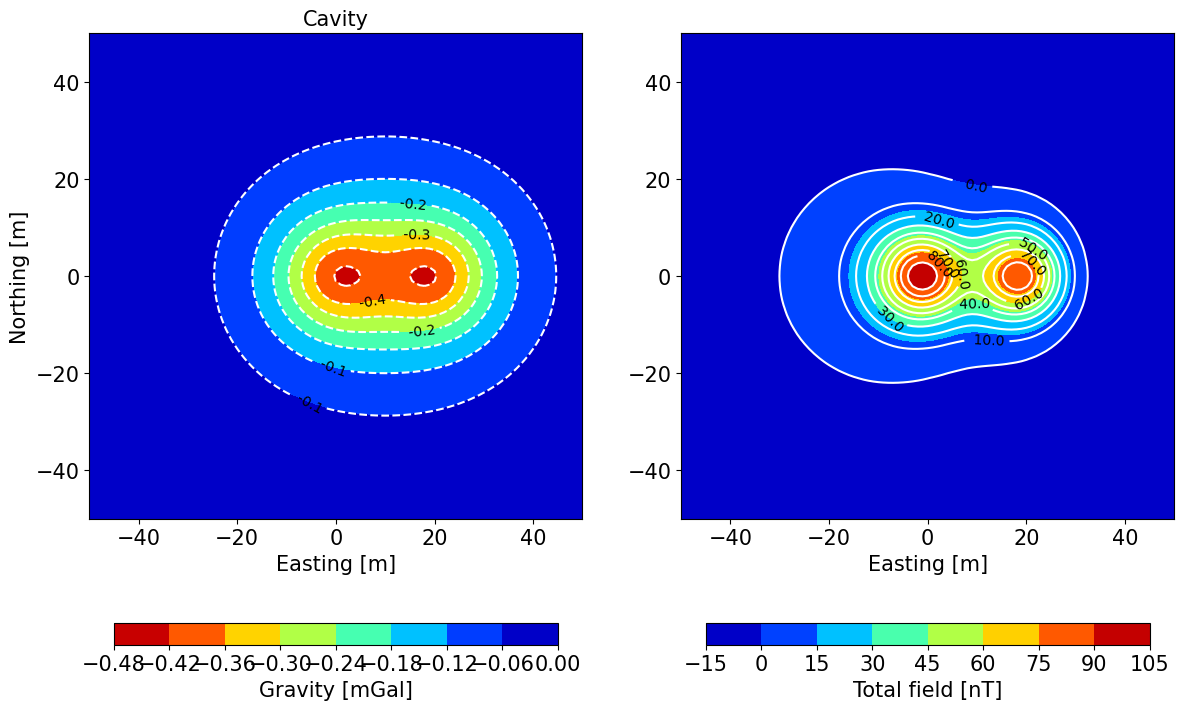

In [8]:
nx=101;ny=101

XP=[0.,20.]
YP=[0.,0.]
ZP=[185.,185.]
RP =[10.,10.]
RHOP =[-2800,-2800]
MAG = [0.4,0.4]

X,Y,TOPO,Z,ZTOP = topo(nx,ny,amplitude=0.0,type=0,plot=False)
signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)

### Three spheres, flat topography

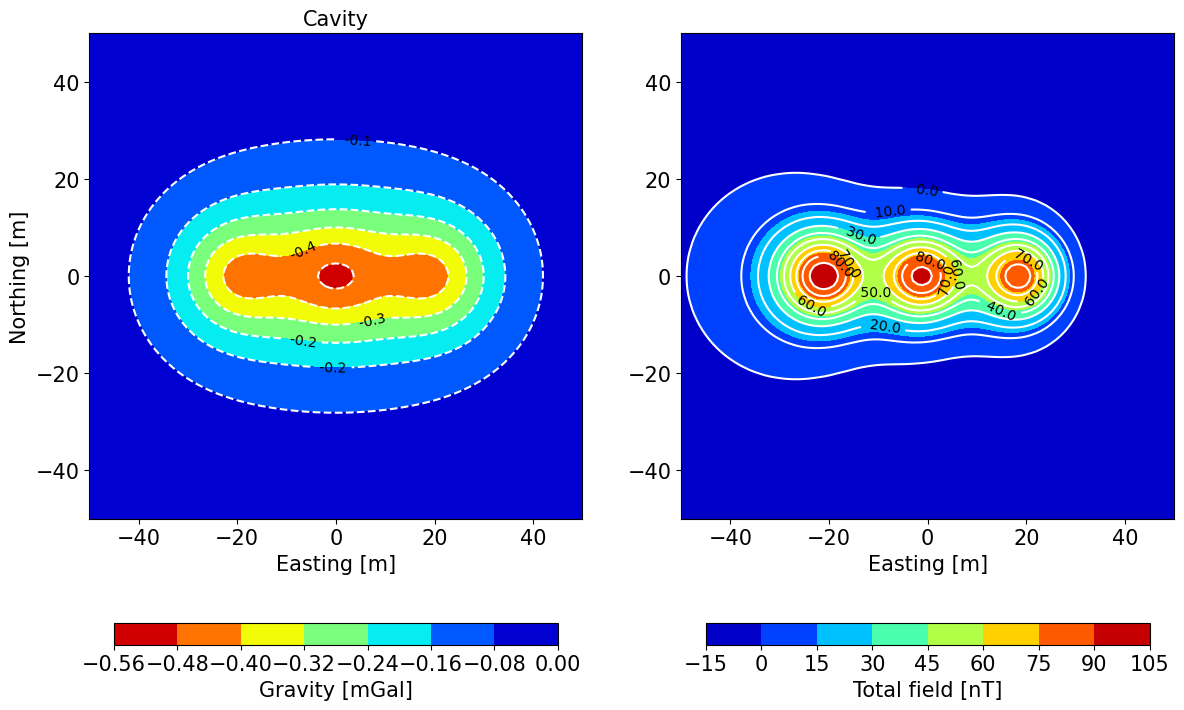

In [9]:
nx=101;ny=101

XP=[-20.,0.,20.]
YP=[0.,0.,0.]
ZP=[185.,185.,185.]
RP =[10.,10.,10.]
RHOP =[-2800,-2800,-2800]
MAG = [0.4,0.4,0.4]

X,Y,TOPO,Z,ZTOP = topo(nx,ny,amplitude=0.0,type=0,plot=False)
signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)

### Three spheres, hill topography

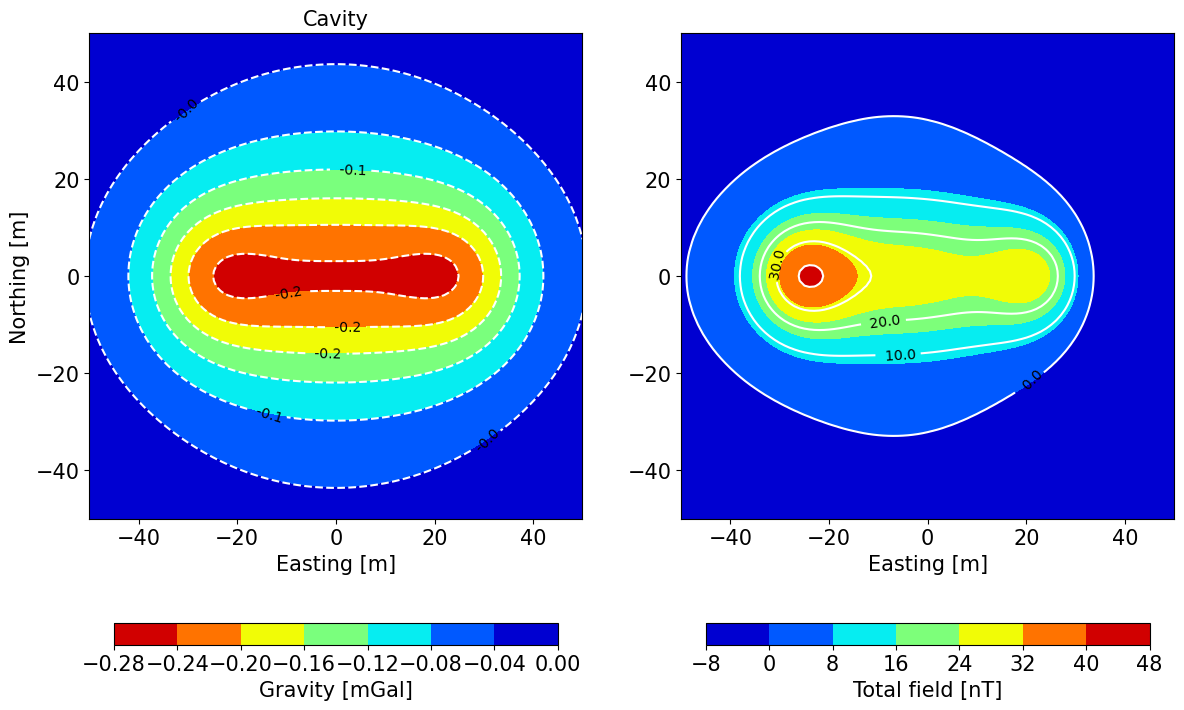

In [10]:
nx=101;ny=101

XP=[-20.,0.,20.]
YP=[0.,0.,0.]
ZP=[185.,185.,185.]
RP =[10.,10.,10.]
RHOP =[-2800,-2800,-2800]
MAG = [0.4,0.4,0.4]

X,Y,TOPO,Z,ZTOP = topo(nx,ny,amplitude=5.0,type=1,plot=False)
signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)

### Three spheres, slope topography

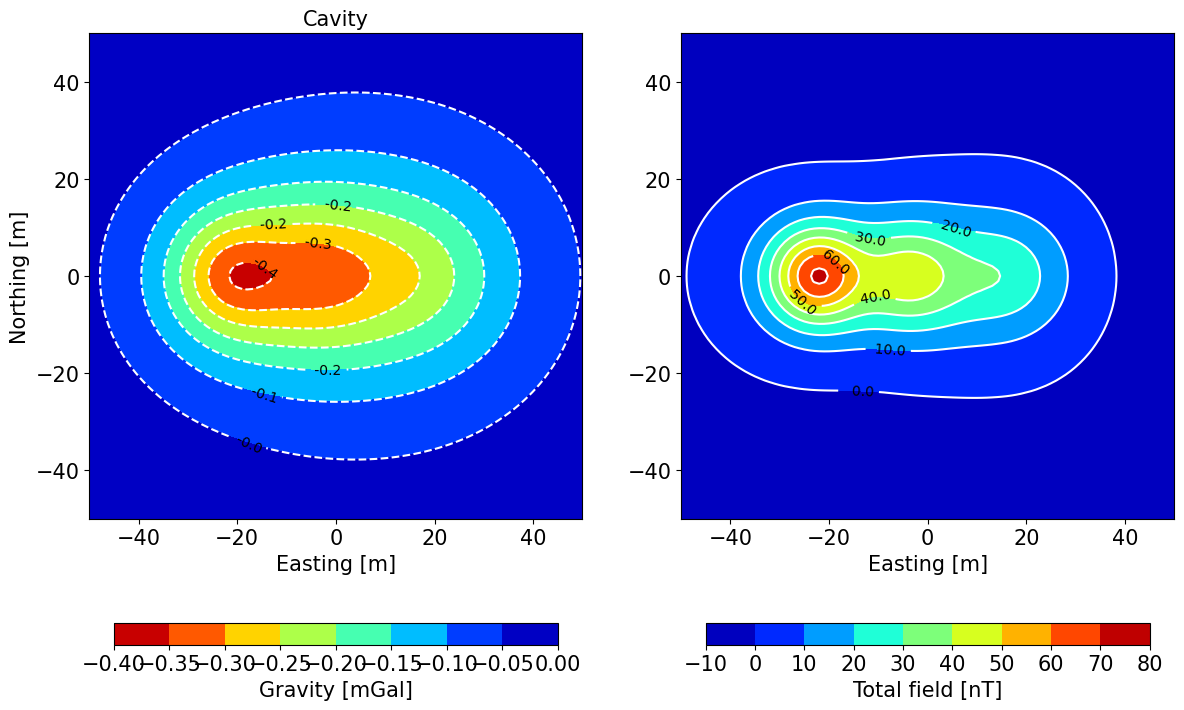

In [11]:
nx=101;ny=101

XP=[-20.,0.,20.]
YP=[0.,0.,0.]
ZP=[185.,185.,185.]
RP =[10.,10.,10.]
RHOP =[-2800,-2800,-2800]
MAG = [0.4,0.4,0.4]

X,Y,TOPO,Z,ZTOP = topo(nx,ny,amplitude=5.0,type=2,plot=False)
signal(nx,ny,X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)

... done